# Import Libraries

In [1]:
from kafka import KafkaConsumer
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import re
import time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Consumer Data

In [2]:
consumer = KafkaConsumer(
    "ml-raw-dns",
    bootstrap_servers="localhost:9092",
    auto_offset_reset="earliest",
    enable_auto_commit=False,
)

# Discard the first row (Column names)
for c in consumer:
    line = c.value
    print(line)
    break

b'"\\u00ef\\u00bb\\u00bftimestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack\\n"'


# Functions

### read_1000_rows

### clean_df

In [3]:
def read_1000_rows():
    rows = []
    i = 0
    for c in consumer:
        line = c.value
        cleaned_line = line.decode("utf-8").strip().replace('"', "").replace("\\n", "")
        values = cleaned_line.split(",")
        rows.append(values)
        i += 1
        if i == 1000:
            break
    temp_df = pd.DataFrame(rows, columns=col_names)
    return temp_df

In [4]:
def clean_df(df):
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    df["timestamp"] = (
        pd.to_datetime(df["timestamp"], format="%M:%S.%f").dt.minute * 60
        + pd.to_datetime(df["timestamp"], format="%M:%S.%f").dt.second
        + pd.to_datetime(df["timestamp"], format="%M:%S.%f").dt.microsecond / 1e6
    ).astype(float)

    df["longest_word"] = df["longest_word"].apply(
        lambda x: len(str(x)) if not str(x).isdigit() else x
    )
    df["sld"] = df["sld"].map(value_counts).fillna(0)

### evaluate_model

In [5]:
def evaluate_model(model, X, y):
    y_pred_static = model.predict(X)
    acc = accuracy_score(y, y_pred_static)
    f1 = f1_score(y, y_pred_static)
    recall = recall_score(y, y_pred_static)
    precision = precision_score(y, y_pred_static)
    return acc, f1, recall, precision

### retrain_model

In [6]:
# use the XGB's parameter(xgb_model) tp retrain the old model allowing training continuation
def retrain_model(model, temp_df):
    new_model = model.fit(
        temp_df[selected_features], temp_df["Target Attack"], xgb_model=model
    )
    return new_model

# Static Data and model

## Data

In [7]:
static_df = pd.read_csv("Static_dataset.csv")
value_counts = static_df[
    "sld"
].value_counts()  # take the value counts of the sld column to use later for transforming the sld column

In [8]:
col_names = [
    "timestamp",
    "FQDN_count",
    "subdomain_length",
    "upper",
    "lower",
    "numeric",
    "entropy",
    "special",
    "labels",
    "labels_max",
    "labels_average",
    "longest_word",
    "sld",
    "len",
    "subdomain",
    "Target Attack",
]
selected_features = [
    "sld",
    "labels",
    "special",
    "entropy",
    "FQDN_count",
    "lower",
    "labels_average",
    "labels_max",
]

## Model

In [9]:
pickle.load(open("model.pkl", "rb"))

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.25, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=150, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [10]:
pipe_static = pickle.load(open("model.pkl", "rb"))
static_model = pipe_static.named_steps["classifier"]  # get the model from the pipeline


pipe_dynamic = pickle.load(open("model.pkl", "rb"))
scaler = pipe_dynamic.named_steps["scaler"]  # get the scaler from the pipeline
Dynamic_model = pipe_dynamic.named_steps[
    "classifier"
]  # get the model from the pipeline

# Dynamic Model

In [11]:
static_list = []
dynamic_list = []
dynamic_time = []
static_time = []
retrain = 0
F1_threshold = 0.855

for i in range(260):
    print("Iteration: ", i + 1)

    # Read 1000 rows from Kafka
    temp_df = read_1000_rows()
    clean_df(temp_df)
    temp_df = pd.DataFrame(scaler.transform(temp_df), columns=temp_df.columns)
    X = temp_df[selected_features]
    y = temp_df["Target Attack"].astype(int)

    # Evaluate static model
    start_static = time.time()  # start timer for static model
    metrics_static = evaluate_model(
        static_model, X, y
    )  # this saves the metrics of the static model in a tuple
    end_static = time.time()  # end timer for static model

    # Evaluate and retrain dynamic model using XGB's continuation training
    start_dynamic = time.time()  # start timer for dynamic model
    metrics_dynamic = evaluate_model(Dynamic_model, X, y)
    print("Static model F1 score: ", metrics_static[1])
    print("Dynamic model F1 score: ", metrics_dynamic[1])
    if metrics_dynamic[1] < F1_threshold:
        retrain += 1  # Count the number of times the dynamic model was retrained
        print("Dynamic model retrained")
        Dynamic_model = retrain_model(Dynamic_model, temp_df)
        metrics_dynamic = evaluate_model(Dynamic_model, X, y)
        print("Dynamic model F1 score after retraining: ", metrics_dynamic[1])
    end_dynamic = time.time()  # end timer for dynamic model

    # Append metrics and time to lists
    dynamic_time.append(end_dynamic - start_dynamic)
    static_time.append(end_static - start_static)
    static_list.append(metrics_static)
    dynamic_list.append(metrics_dynamic)
    print("*****************************************************************")

print("\n\n")
print(
    "Average static model F1 Score: ", np.mean([metrics[1] for metrics in static_list])
)
print(
    "Average dynamic model F1 Score: ",
    np.mean([metrics[1] for metrics in dynamic_list]),
)
print("Number of times dynamic model retrained: ", retrain)

Iteration:  1
Static model F1 score:  0.8351822503961965
Dynamic model F1 score:  0.8351822503961965
Dynamic model retrained
Dynamic model F1 score after retraining:  0.8486312399355878
*****************************************************************
Iteration:  2
Static model F1 score:  0.842023346303502
Dynamic model F1 score:  0.8539857932123127
Dynamic model retrained
Dynamic model F1 score after retraining:  0.8533123028391167
*****************************************************************
Iteration:  3
Static model F1 score:  0.8341013824884793
Dynamic model F1 score:  0.8418604651162791
Dynamic model retrained
Dynamic model F1 score after retraining:  0.8425135764158262
*****************************************************************
Iteration:  4
Static model F1 score:  0.8478915662650603
Dynamic model F1 score:  0.858678955453149
*****************************************************************
Iteration:  5
Static model F1 score:  0.8375394321766562
Dynamic model F1 score

# Comparison

## Metrics Plots

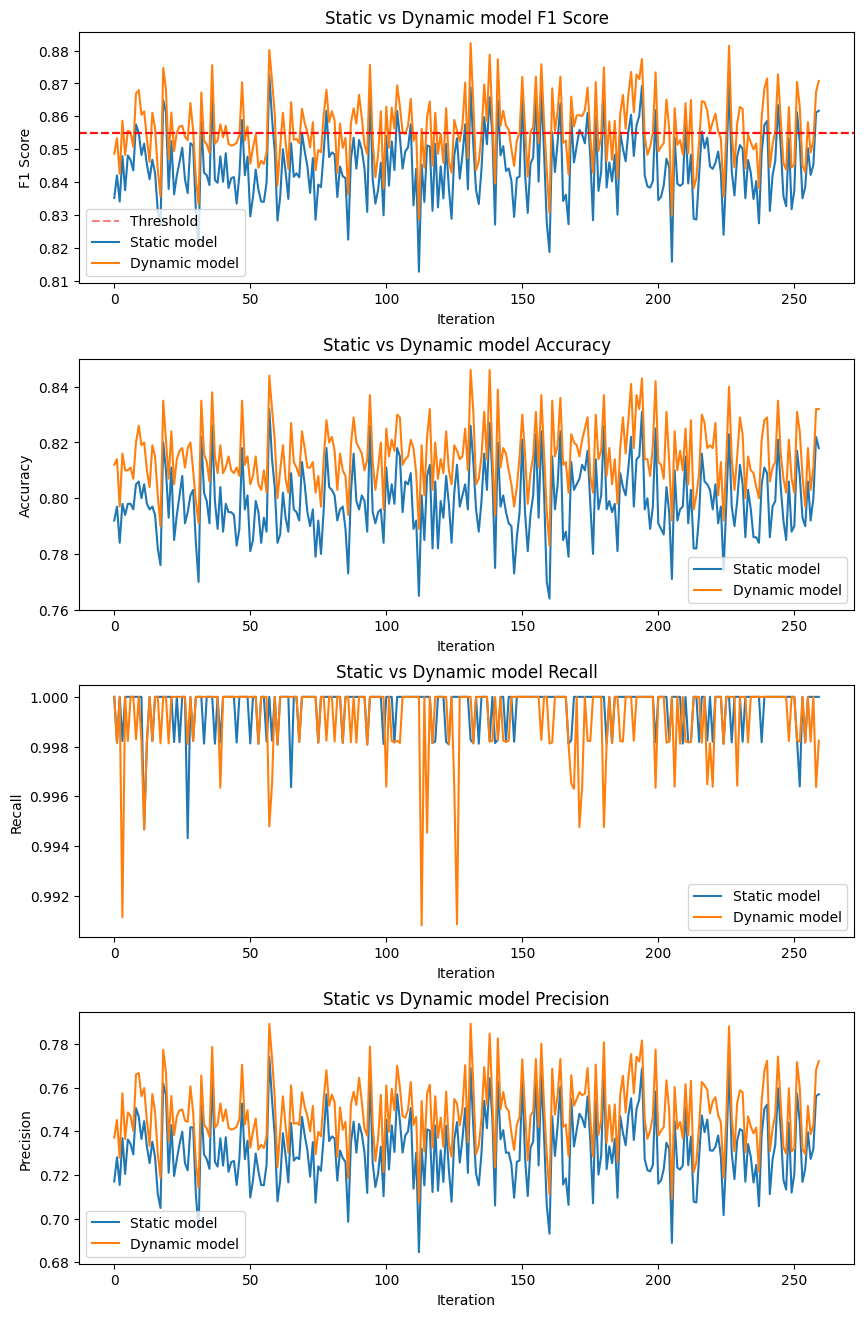

In [12]:
import matplotlib.pyplot as plt

# Metrics labels and corresponding list of metrics
metrics_labels = ["F1 Score", "Accuracy", "Recall", "Precision"]
static_metrics = [
    [metrics[1] for metrics in static_list],
    [metrics[0] for metrics in static_list],
    [metrics[2] for metrics in static_list],
    [metrics[3] for metrics in static_list],
]
dynamic_metrics = [
    [metrics[1] for metrics in dynamic_list],
    [metrics[0] for metrics in dynamic_list],
    [metrics[2] for metrics in dynamic_list],
    [metrics[3] for metrics in dynamic_list],
]

# Create subplots with 4 rows and 1 column
fig, axs = plt.subplots(4, 1, figsize=(10, 16))

# Iterate over metrics and plot
for i, (ax, label, static_metric, dynamic_metric) in enumerate(
    zip(axs, metrics_labels, static_metrics, dynamic_metrics)
):
    axs[0].axhline(
        y=F1_threshold, color="r", linestyle="--", label="Threshold", alpha=0.5
    )
    ax.plot(static_metric, label="Static model")
    ax.plot(dynamic_metric, label="Dynamic model")
    ax.set_xlabel("Iteration")
    ax.set_ylabel(label)
    ax.set_title(f"Static vs Dynamic model {label}")
    ax.legend()
plt.subplots_adjust(hspace=0.3)
plt.show()

## Time Plot

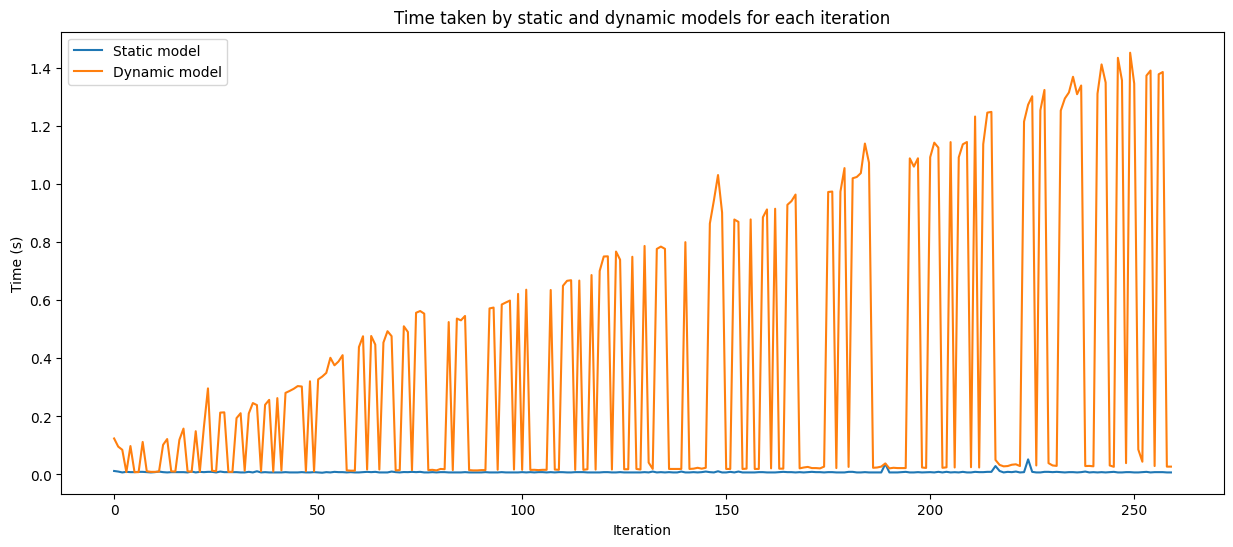

In [13]:
# plot the time taken for each iteration
plt.figure(figsize=(15, 6))
plt.plot(static_time, label="Static model")
plt.plot(dynamic_time, label="Dynamic model")
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title("Time taken by static and dynamic models for each iteration")
plt.legend()
plt.show()

## Time Comparison

In [17]:
# compare between the time taken for each model using prettytable
y = PrettyTable()
y.field_names = ["Model", "Total Time (s)", "Average Time (s)"]
y.add_row(
    [
        "Static",
        np.sum(static_time),
        np.mean(static_time),
    ]
)
y.add_row(
    [
        "Dynamic",
        np.sum(dynamic_time),
        np.mean(dynamic_time),
    ]
)
print(y)

+---------+-------------------+----------------------+
|  Model  |   Total Time (s)  |   Average Time (s)   |
+---------+-------------------+----------------------+
|  Static | 2.116063117980957 | 0.008138704299926757 |
| Dynamic | 102.1717209815979 | 0.39296815762153037  |
+---------+-------------------+----------------------+


## Average Metrics

In [15]:
x = PrettyTable()
x.field_names = [
    "Model",
    "Average F1 Score",
    "Average Accuracy",
    "Average Recall",
    "Average Precision",
]
x.add_row(
    [
        "Static",
        np.mean([metrics[1] for metrics in static_list]),
        np.mean([metrics[0] for metrics in static_list]),
        np.mean([metrics[2] for metrics in static_list]),
        np.mean([metrics[3] for metrics in static_list]),
    ]
)
x.add_row(
    [
        "Dynamic",
        np.mean([metrics[1] for metrics in dynamic_list]),
        np.mean([metrics[0] for metrics in dynamic_list]),
        np.mean([metrics[2] for metrics in dynamic_list]),
        np.mean([metrics[3] for metrics in dynamic_list]),
    ]
)
print(x)

+---------+--------------------+--------------------+--------------------+--------------------+
|  Model  |  Average F1 Score  |  Average Accuracy  |   Average Recall   | Average Precision  |
+---------+--------------------+--------------------+--------------------+--------------------+
|  Static | 0.8450483973516986 | 0.7988192307692307 | 0.9995641503856895 | 0.7320552537953664 |
| Dynamic |  0.85577835107624  | 0.8151692307692308 | 0.9991940093149109 | 0.748504056060965  |
+---------+--------------------+--------------------+--------------------+--------------------+
